In [6]:
using LinearAlgebra
using Random
using Distributions
using KernelDensity
include("../Inversion/Plot.jl")
include("../Inversion/GMBBVI.jl")
include("./MultiModal.jl")
Random.seed!(111);

## Gaussian mixture

We test GMBBVI with Gaussian mixture target densities

$$
\rho_{\rm post}(\theta) = \sum_i w_i \mathcal{N}(\theta; m_i, C_i) \propto e^{-\Phi_r(\theta)} \qquad
\Phi_r(\theta) = - \log\Bigl( \sum_i w_i \mathcal{N}(\theta; m_i, C_i) \Bigr)
$$


In [7]:
function log_Gaussian_mixture(x, args)
    x_w, x_mean, inv_sqrt_x_cov = args
    # C = L L.T
    # C^-1 = L^-TL^-1
    N_x = size(x_mean, 2)
    ρ = 0
    exponents = [-0.5*(x-x_mean[im,:])'*(inv_sqrt_x_cov[im]'*inv_sqrt_x_cov[im]*(x-x_mean[im,:])) for im =1:length(x_w)]
    mexponent = maximum(exponents)
    for im = 1:length(x_w)
        ρ += x_w[im]*exp(exponents[im] - mexponent)*det(inv_sqrt_x_cov[im])
    end
    return  log(ρ) + mexponent - N_x/2*log(2*π)
end


function Gaussian_mixture_dPhi(θ, args)
    return -log_Gaussian_mixture(θ, args), 
           -ForwardDiff.gradient(x -> log_Gaussian_mixture(x, args), θ), 
           -ForwardDiff.hessian(x -> log_Gaussian_mixture(x, args), θ)
end

Gaussian_mixture_dPhi (generic function with 1 method)

In [8]:
function visualization_comparison(ax, obj_GMBBVI; Nx = 200, Ny = 200, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0],
    x_w_ref, x_mean_ref, xx_cov_ref)
    
    x_min, x_max = x_lim
    y_min, y_max = y_lim
    boundary=((x_lim[1],x_lim[2]),(y_lim[1],y_lim[2]))

    xx = LinRange(x_min, x_max, Nx)
    yy = LinRange(y_min, y_max, Ny)
    dx, dy = xx[2] - xx[1], yy[2] - yy[1]
    X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)'
    Z_ref = Gaussian_mixture_2d(x_w_ref, x_mean_ref[:,1:2], xx_cov_ref[:,1:2,1:2],  X, Y)
    color_lim = (minimum(Z_ref), maximum(Z_ref))
    
        
    ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)

    error = zeros(N_iter+1)
    for iter = 0:N_iter
        x_w = exp.(obj_GMBBVI.logx_w[iter+1]); x_w /= sum(x_w)
        x_mean = obj_GMBBVI.x_mean[iter+1][:,1:2]
        xx_cov = obj_GMBBVI.xx_cov[iter+1][:,1:2,1:2]
        Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
        error[iter+1] = norm(Z - Z_ref,1)*dx*dy
        if iter == N_iter  
            ax[2].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
            ax[2].scatter([obj_GMBBVI.x_mean[1][:,1];], [obj_GMBBVI.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
            ax[2].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)
        
        end
    end

    ax[3].semilogy(Array(0:N_iter), error, label="GMBBVI") 


end




visualization_comparison (generic function with 1 method)

[ Info: ("iter = ", 50, " / ", 500)
[ Info: ("iter = ", 100, " / ", 500)
[ Info: ("iter = ", 150, " / ", 500)
[ Info: ("iter = ", 200, " / ", 500)
[ Info: ("iter = ", 250, " / ", 500)
[ Info: ("iter = ", 300, " / ", 500)
[ Info: ("iter = ", 350, " / ", 500)
[ Info: ("iter = ", 400, " / ", 500)
[ Info: ("iter = ", 450, " / ", 500)
[ Info: ("iter = ", 500, " / ", 500)
[ Info: ("GMBBVI time = ", 24.498843908309937)


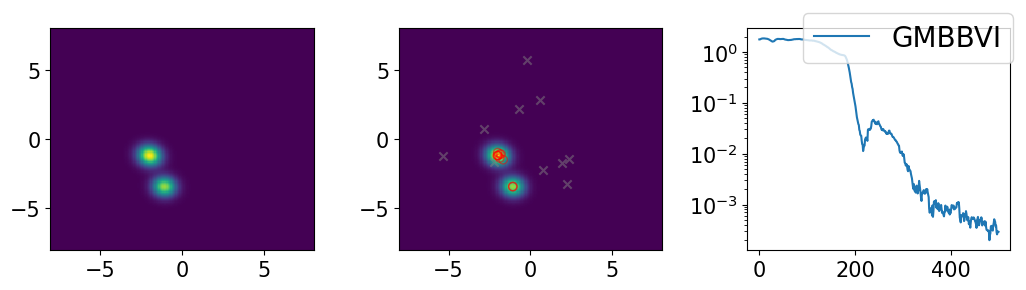

In [9]:
###### Reference 
Random.seed!(11)
N_x = 50
N_modes = 2
x_w_ref =  rand(Uniform(0,1), N_modes) 
x_w_ref = x_w_ref/sum(x_w_ref)
x_mean_ref = 3.0*rand(Normal(0, 1), (N_modes, N_x))
xx_cov_ref = zeros(N_modes, N_x, N_x)
inv_sqrt_xx_cov_ref = []
for i = 1:N_modes
    W = rand(Normal(0, 1), (N_x, N_x))
    xx_cov_ref[i,:,:] = 0.25*(W'*W/N_x + I)/2.0
    push!(inv_sqrt_xx_cov_ref, inv(cholesky(xx_cov_ref[i,:,:]).L))
end
func_Phi(x) = -log_Gaussian_mixture(x, (x_w_ref, x_mean_ref, inv_sqrt_xx_cov_ref))

###### Initial condition
N_modes = 10
x0_w  = ones(N_modes)/N_modes
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
μ0, Σ0 = zeros(N_x), Diagonal(ones(N_x))
for im = 1:N_modes
    x0_mean[im, :]    .= 3.0*rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end

###### GMBBVI
N_iter = 500
dt = 0.5
N_ens= 4*N_x
t0 = time()
GMBBVI = Gaussian_mixture_GMBBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt, N_ens = N_ens)
t1  = time()
@info "GMBBVI time = ", t1 - t0

fig, ax = PyPlot.subplots(nrows=1, ncols=3, sharex=false, sharey=false, figsize=(10,3))
visualization_comparison(ax, GMBBVI; Nx = 200, Ny = 200, x_lim=[-8.0, 8.0], y_lim=[-8.0, 8.0], x_w_ref=x_w_ref, x_mean_ref=x_mean_ref, xx_cov_ref=xx_cov_ref)


fig.legend(fontsize=20)

plt.tight_layout()
fig.subplots_adjust(bottom=0.15,top=0.89,left=0.02,right=0.98,hspace=0.2)
